In [207]:
# import warnings
# warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import os
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [97]:
pd.set_option('display.max_columns',50)

os.chdir('../../../card/')

In [64]:
#baseline modeling
# object_col = []
# for col in train.columns:
#     if train[col].dtype == 'object':
#         object_col.append(col)

# enc = OneHotEncoder()
# enc.fit(train.loc[:,object_col])


# train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
#              columns=enc.get_feature_names(object_col))
# train.drop(object_col, axis=1, inplace=True)
# train = pd.concat([train, train_onehot_df], axis=1)

# test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
#              columns=enc.get_feature_names(object_col))
# test.drop(object_col, axis=1, inplace=True)
# test = pd.concat([test, test_onehot_df], axis=1)

In [197]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
#     plt.savefig('lgbm_importances-01.png')
    plt.show()

def plotImpModels(models, X , num = 20):
    for model in models.values():
        feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
        plt.figure(figsize=(40, 20))
        sns.set(font_scale = 5)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                            ascending=False)[0:num])
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
    #     plt.savefig('lgbm_importances-01.png')
        plt.show()

In [298]:
train = pd.read_csv('train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('sample_submission.csv')

In [299]:
train['F_new_occ_income'] =train['income_type'] +"_"+train['occyp_type']
test['F_new_occ_income'] =test['income_type'] +"_"+test['occyp_type']


In [300]:
def TransDayToDate(df):
    target = df.copy()
    target.loc[target.DAYS_EMPLOYED >0,'DAYS_EMPLOYED'] =0
    target['F_age'] = round(-target.DAYS_BIRTH/ (365.25) +1)
    target['DAYS_EMPLOYED']  =abs(target['DAYS_EMPLOYED'])
    target['begin_month']    =abs(target['begin_month'])
    target['F_DAYS_EMPLOYED_month'] =(target['DAYS_EMPLOYED']/30).astype('int')
    target['F_WorkStartAge']  = target['F_age'] - (target['DAYS_EMPLOYED']/365).astype('int')
    
    
    return target

trainTime =TransDayToDate(train)
testTime =TransDayToDate(test)

drop_col = ['DAYS_BIRTH','FLAG_MOBIL']

try:
    model_train = trainTime.drop(drop_col,axis=1)
    model_test = testTime.drop(drop_col,axis=1)
except:
    pass

from sklearn.ensemble import RandomForestClassifier

def checkUniqueObject(train,test):
    target_col = train.select_dtypes(include= object).columns
    
    check =0
    for col in target_col:
        trainU = train[col].unique()
        testU  = test[col].unique()

        if set(trainU) != set(testU):
            print(col,' have not same Unique values')
            check=1
            
    if check ==0:
        print('all columns have Same Unique values')

checkUniqueObject(train,test)

def LabelEn(train,test):
    trainLa = train.copy()
    testLa  = test.copy()
    
    from sklearn.preprocessing import LabelEncoder
    target_col = train.select_dtypes(include= object).columns
    for col in target_col:
        le = LabelEncoder()
        le.fit(trainLa[col])
        trainLa[col] = le.transform(trainLa[col])
        for label in np.unique(testLa[col]):
            if label not in le.classes_: # unseen label 데이터인 경우( )
                le.classes_ = np.append(le.classes_, label) # 미처리 시 ValueError발생
        testLa[col] = le.transform(testLa[col])

    
    return trainLa , testLa

trainLa , testLa = LabelEn(model_train,model_test)

F_new_occ_income  have not same Unique values


In [301]:
trainLa= trainLa.drop(['income_type','occyp_type'],axis=1)

In [265]:
import random


# modeling

In [263]:
%%time
train =trainLa
test = testLa

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))


random.seed(42)
lgb_models={}
log_loss_val =[]
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    pred = lgb.predict_proba(X_valid)
    log_loss_v = log_loss(y_valid,pred)
    log_loss_val.append(log_loss_v)
    print(f'================================================================================\n\n')
print('final_ log_loss mean',np.array(log_loss_val).mean())

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.651677	valid_1's multi_logloss: 0.751013
[200]	training's multi_logloss: 0.566267	valid_1's multi_logloss: 0.734747
[300]	training's multi_logloss: 0.503229	valid_1's multi_logloss: 0.728963
Early stopping, best iteration is:
[329]	training's multi_logloss: 0.487088	valid_1's multi_logloss: 0.727393


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.645899	valid_1's multi_logloss: 0.761352
[200]	training's multi_logloss: 0.558861	valid_1's multi_logloss: 0.751104
Early stopping, best iteration is:
[212]	training's multi_logloss: 0.550337	valid_1's multi_logloss: 0.750647


====================================3============================================
Training until validation scores 

In [194]:
#성범님 피쳐 중요도 기준점

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


train =trainLa
Train = train.drop('credit', axis = 1, inplace = False)
target = train['credit']

X_train, X_val, y_train, y_val = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)
print(f"log_loss: {log_loss(to_categorical(y_val), y_pred)}") # 0.7542 -> 0.7511 -> 0.7483 -> 0.7413

# 0.7404 -> 7326
# 0.735
# 0.7281


Train set: 
(19842, 19)
(19842,)
Validation set: 
(6615, 19)
(6615,)
log_loss: 0.7588799404601113


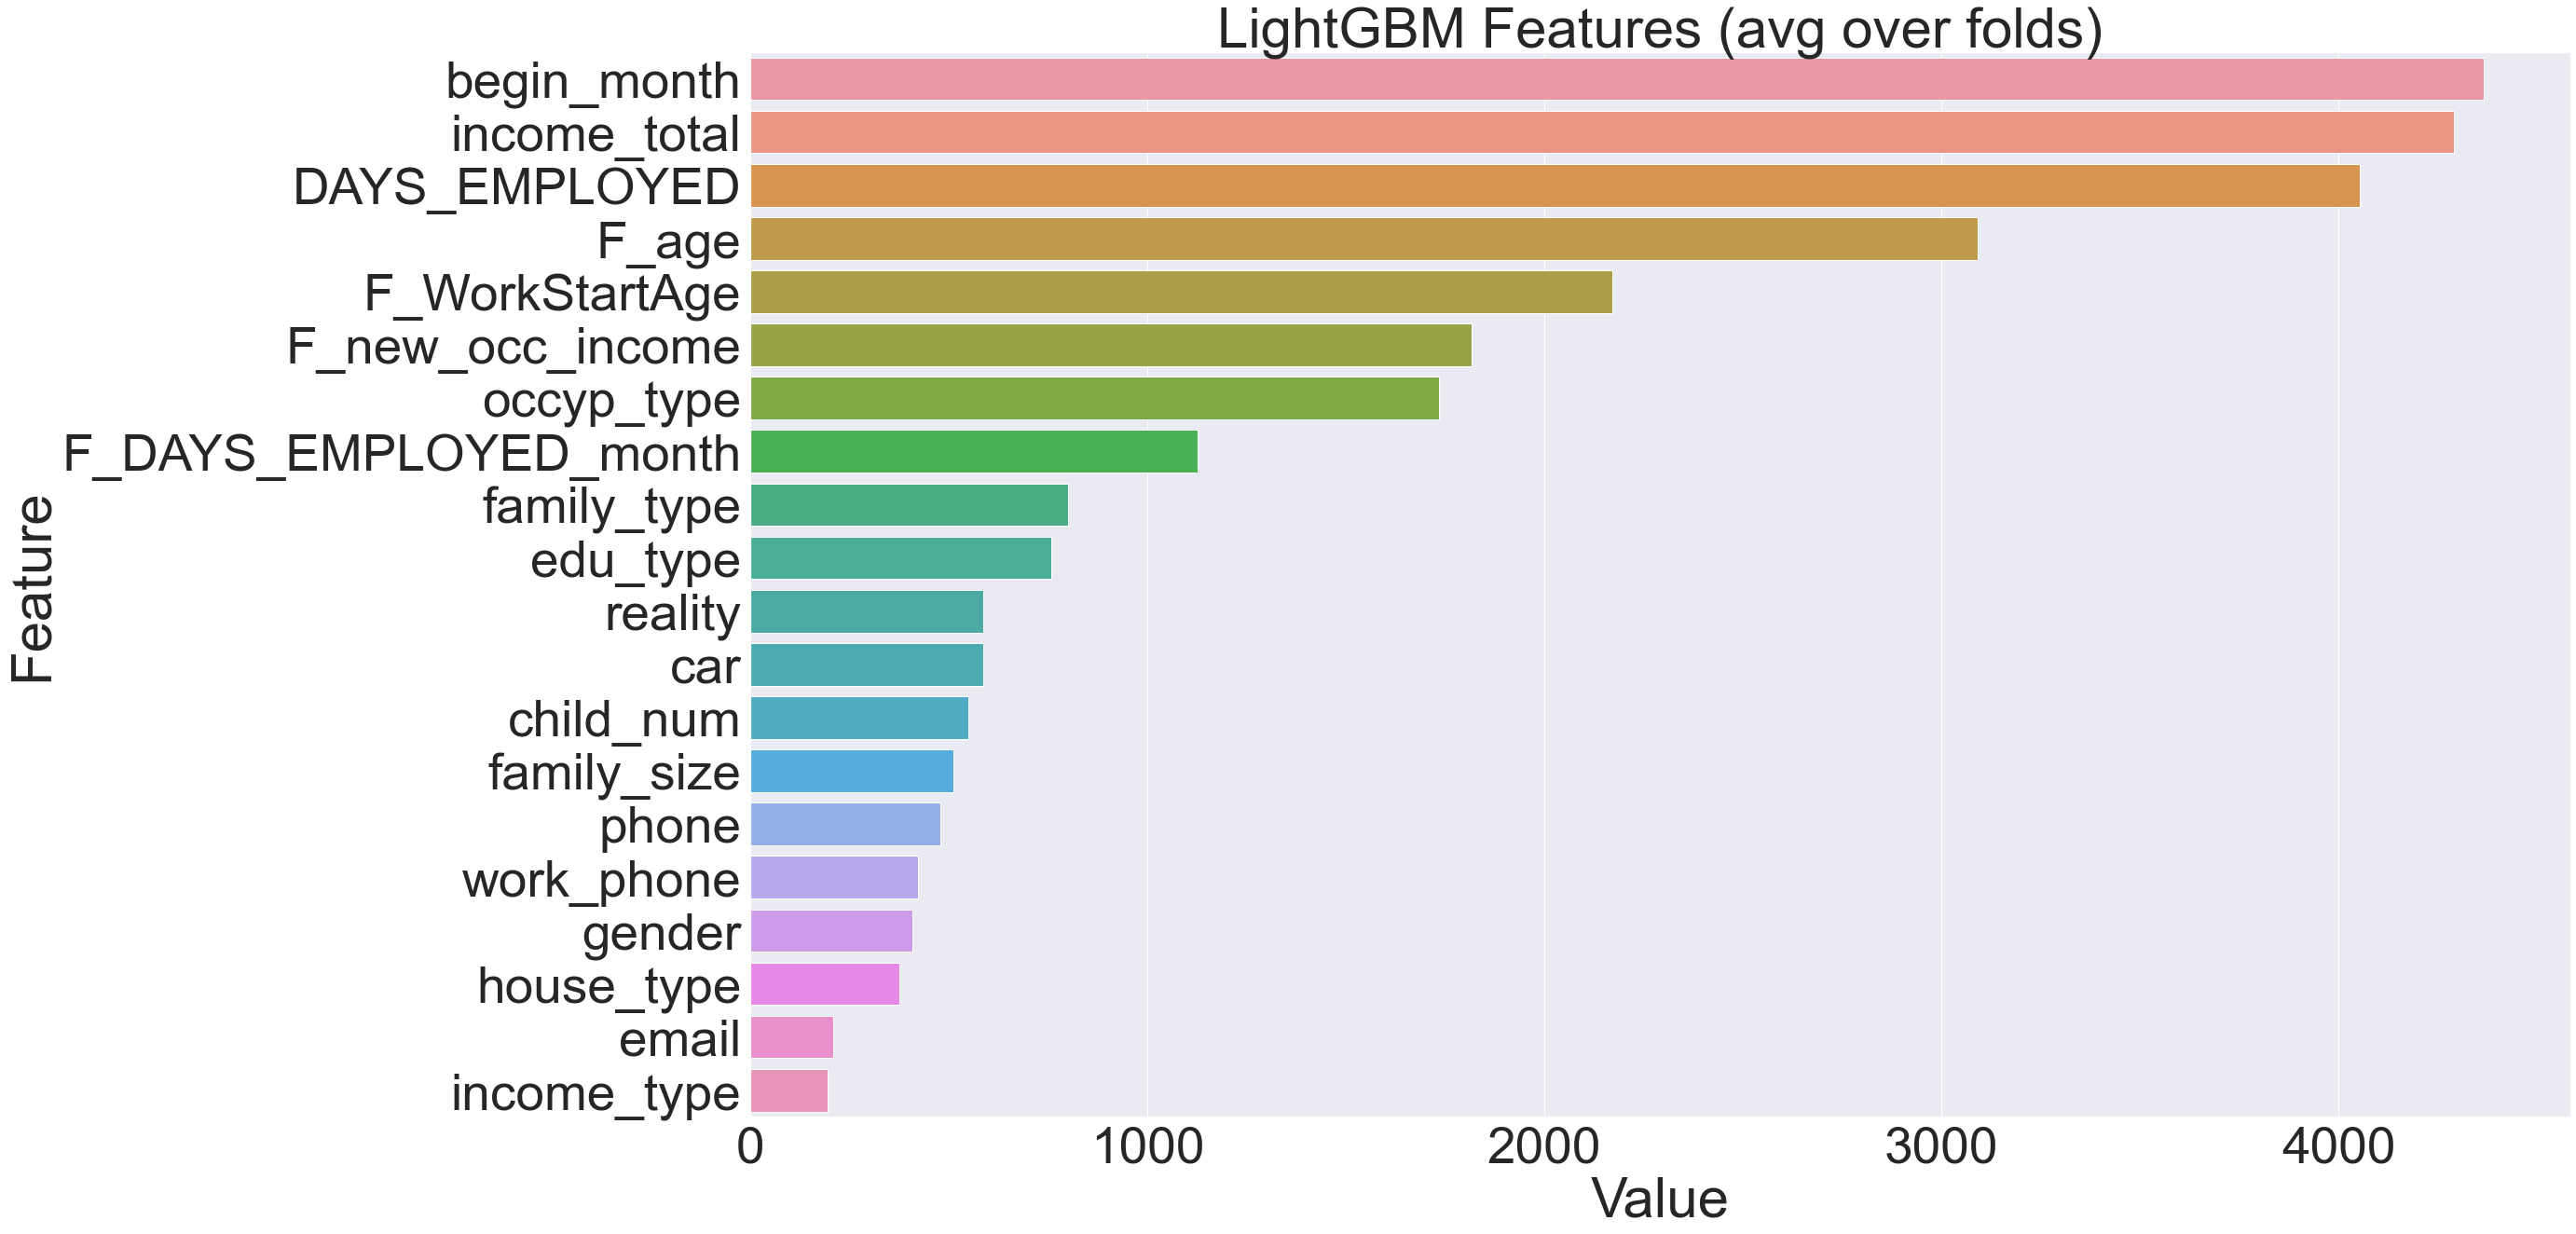

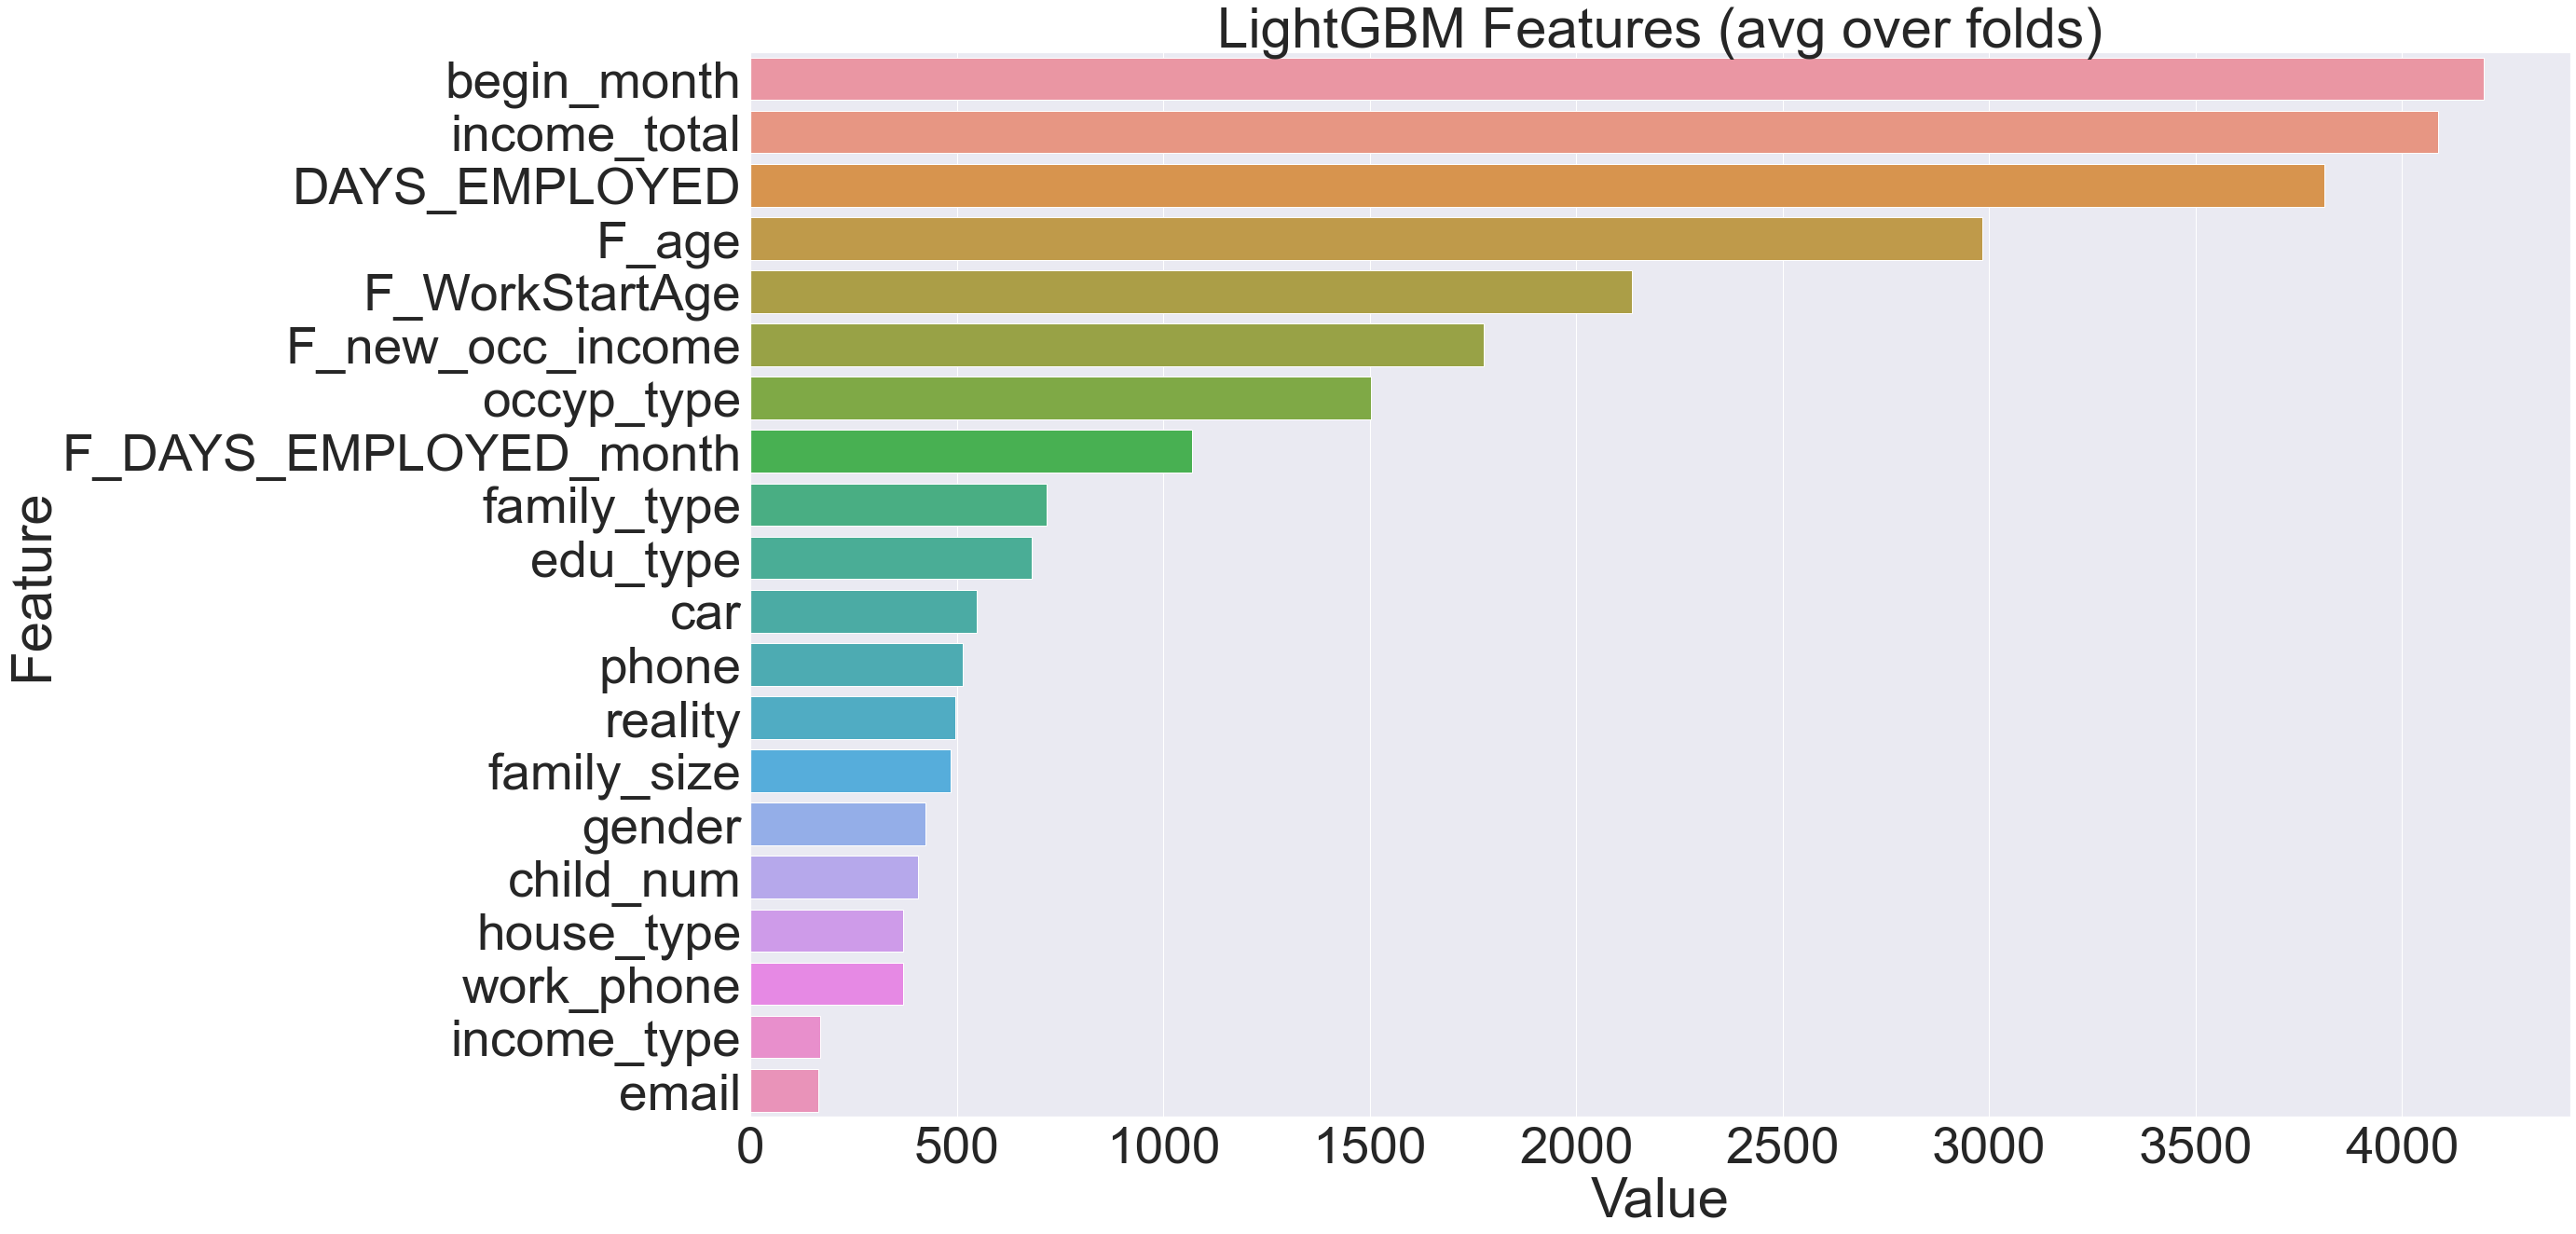

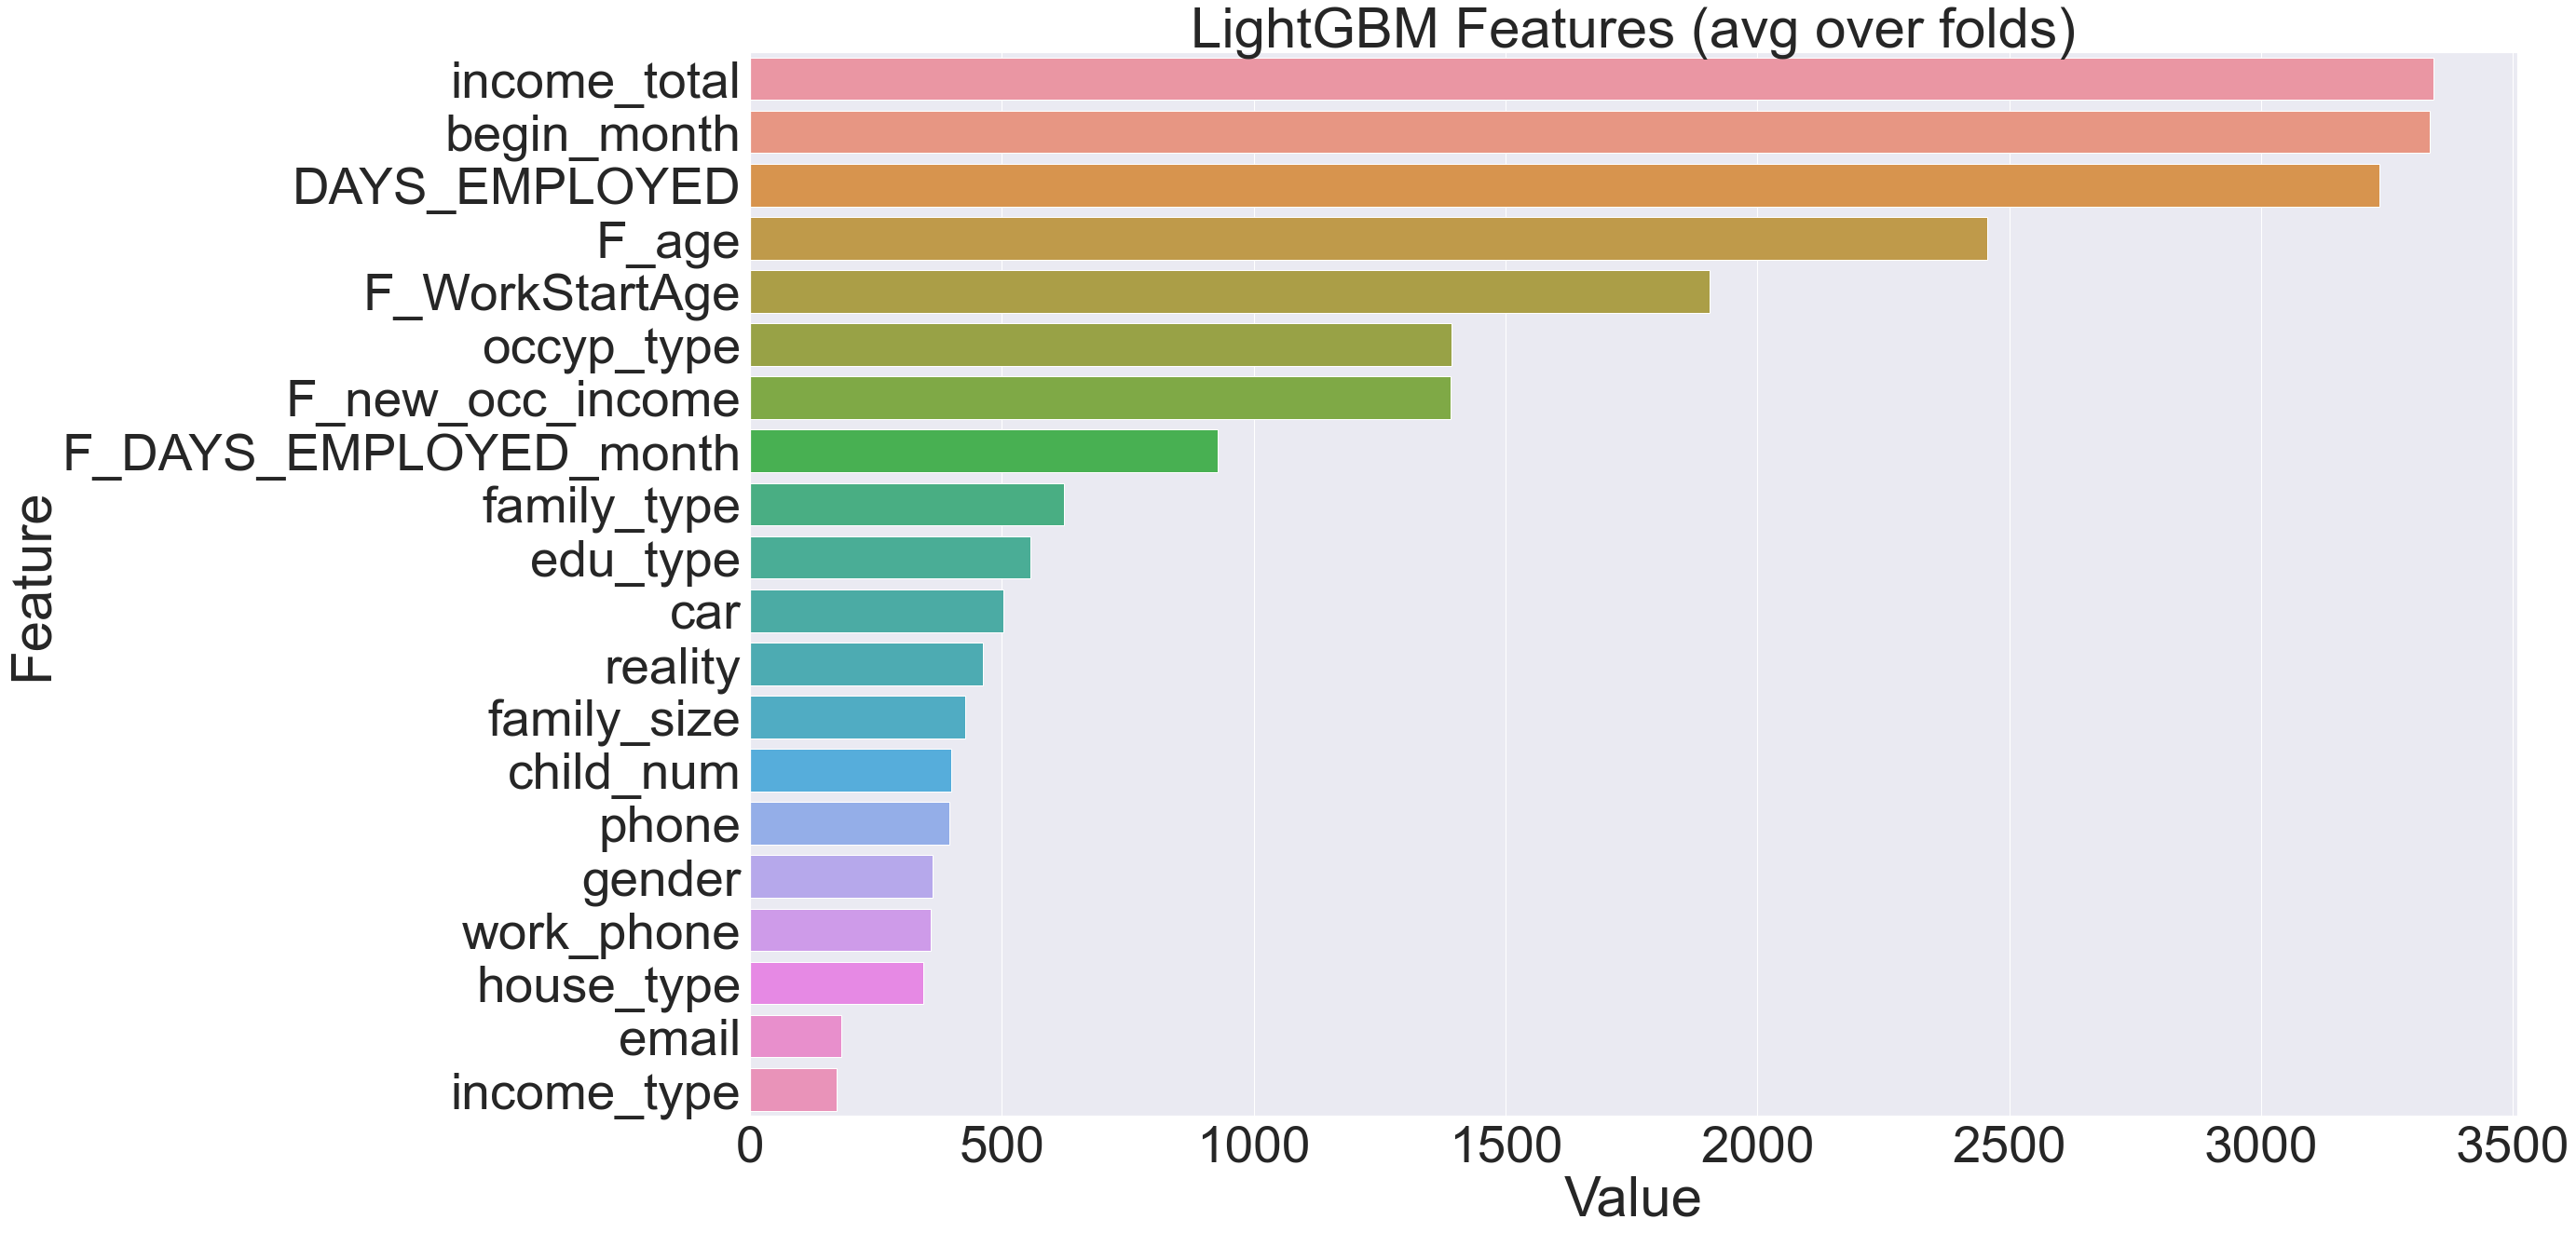

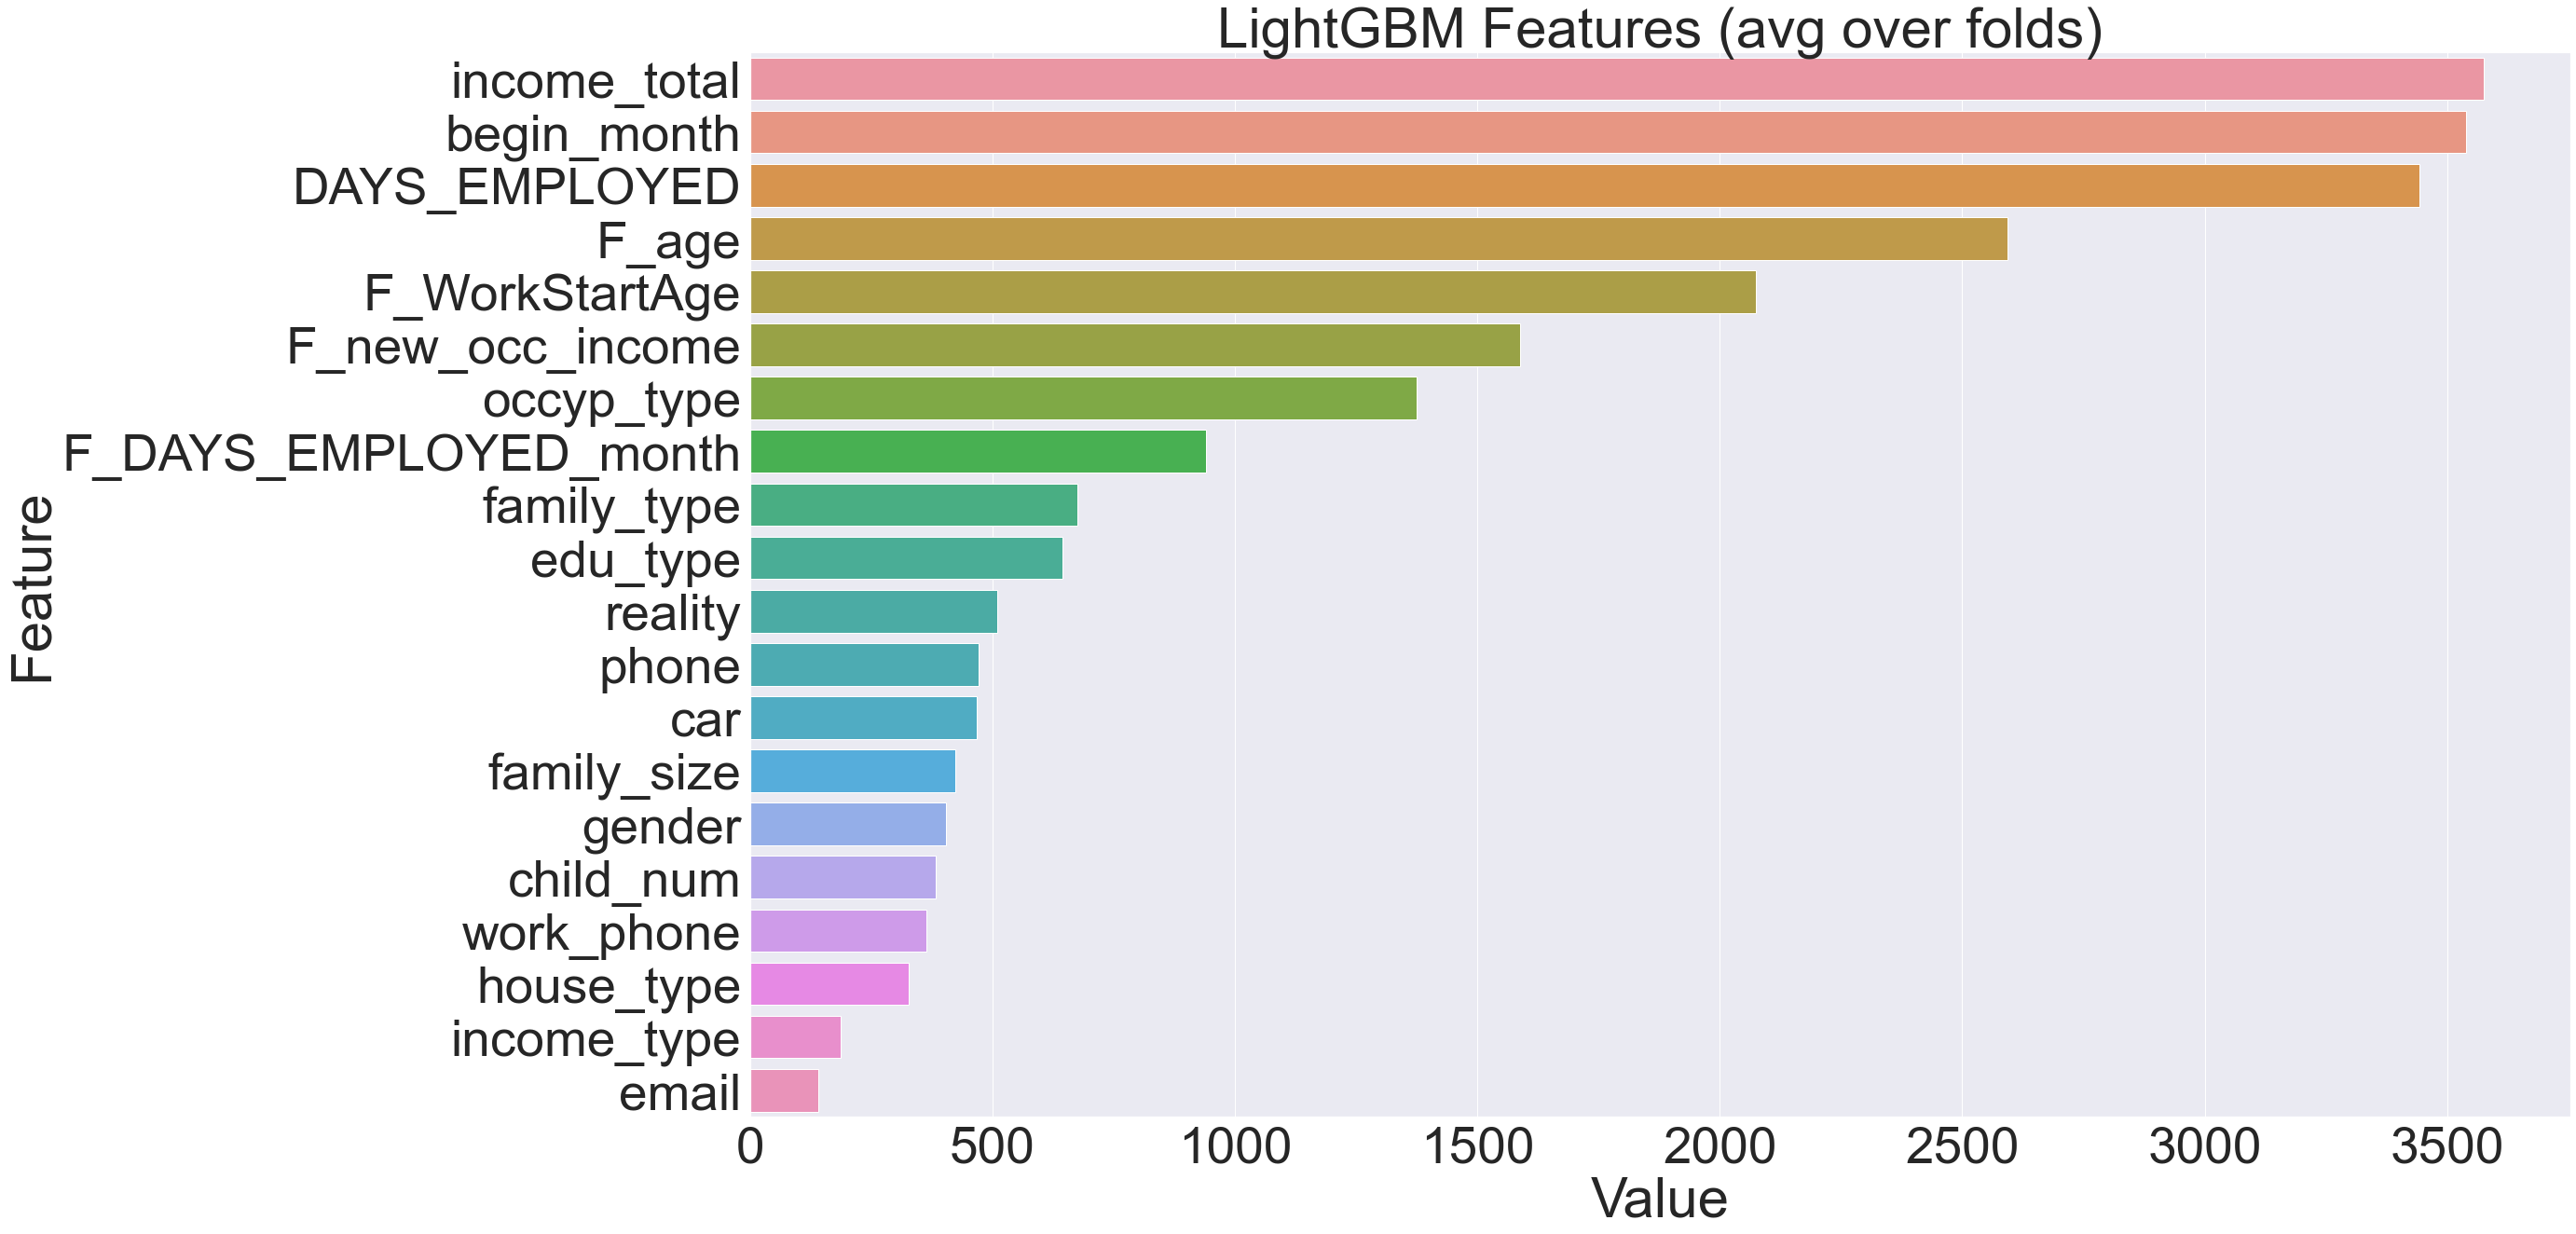

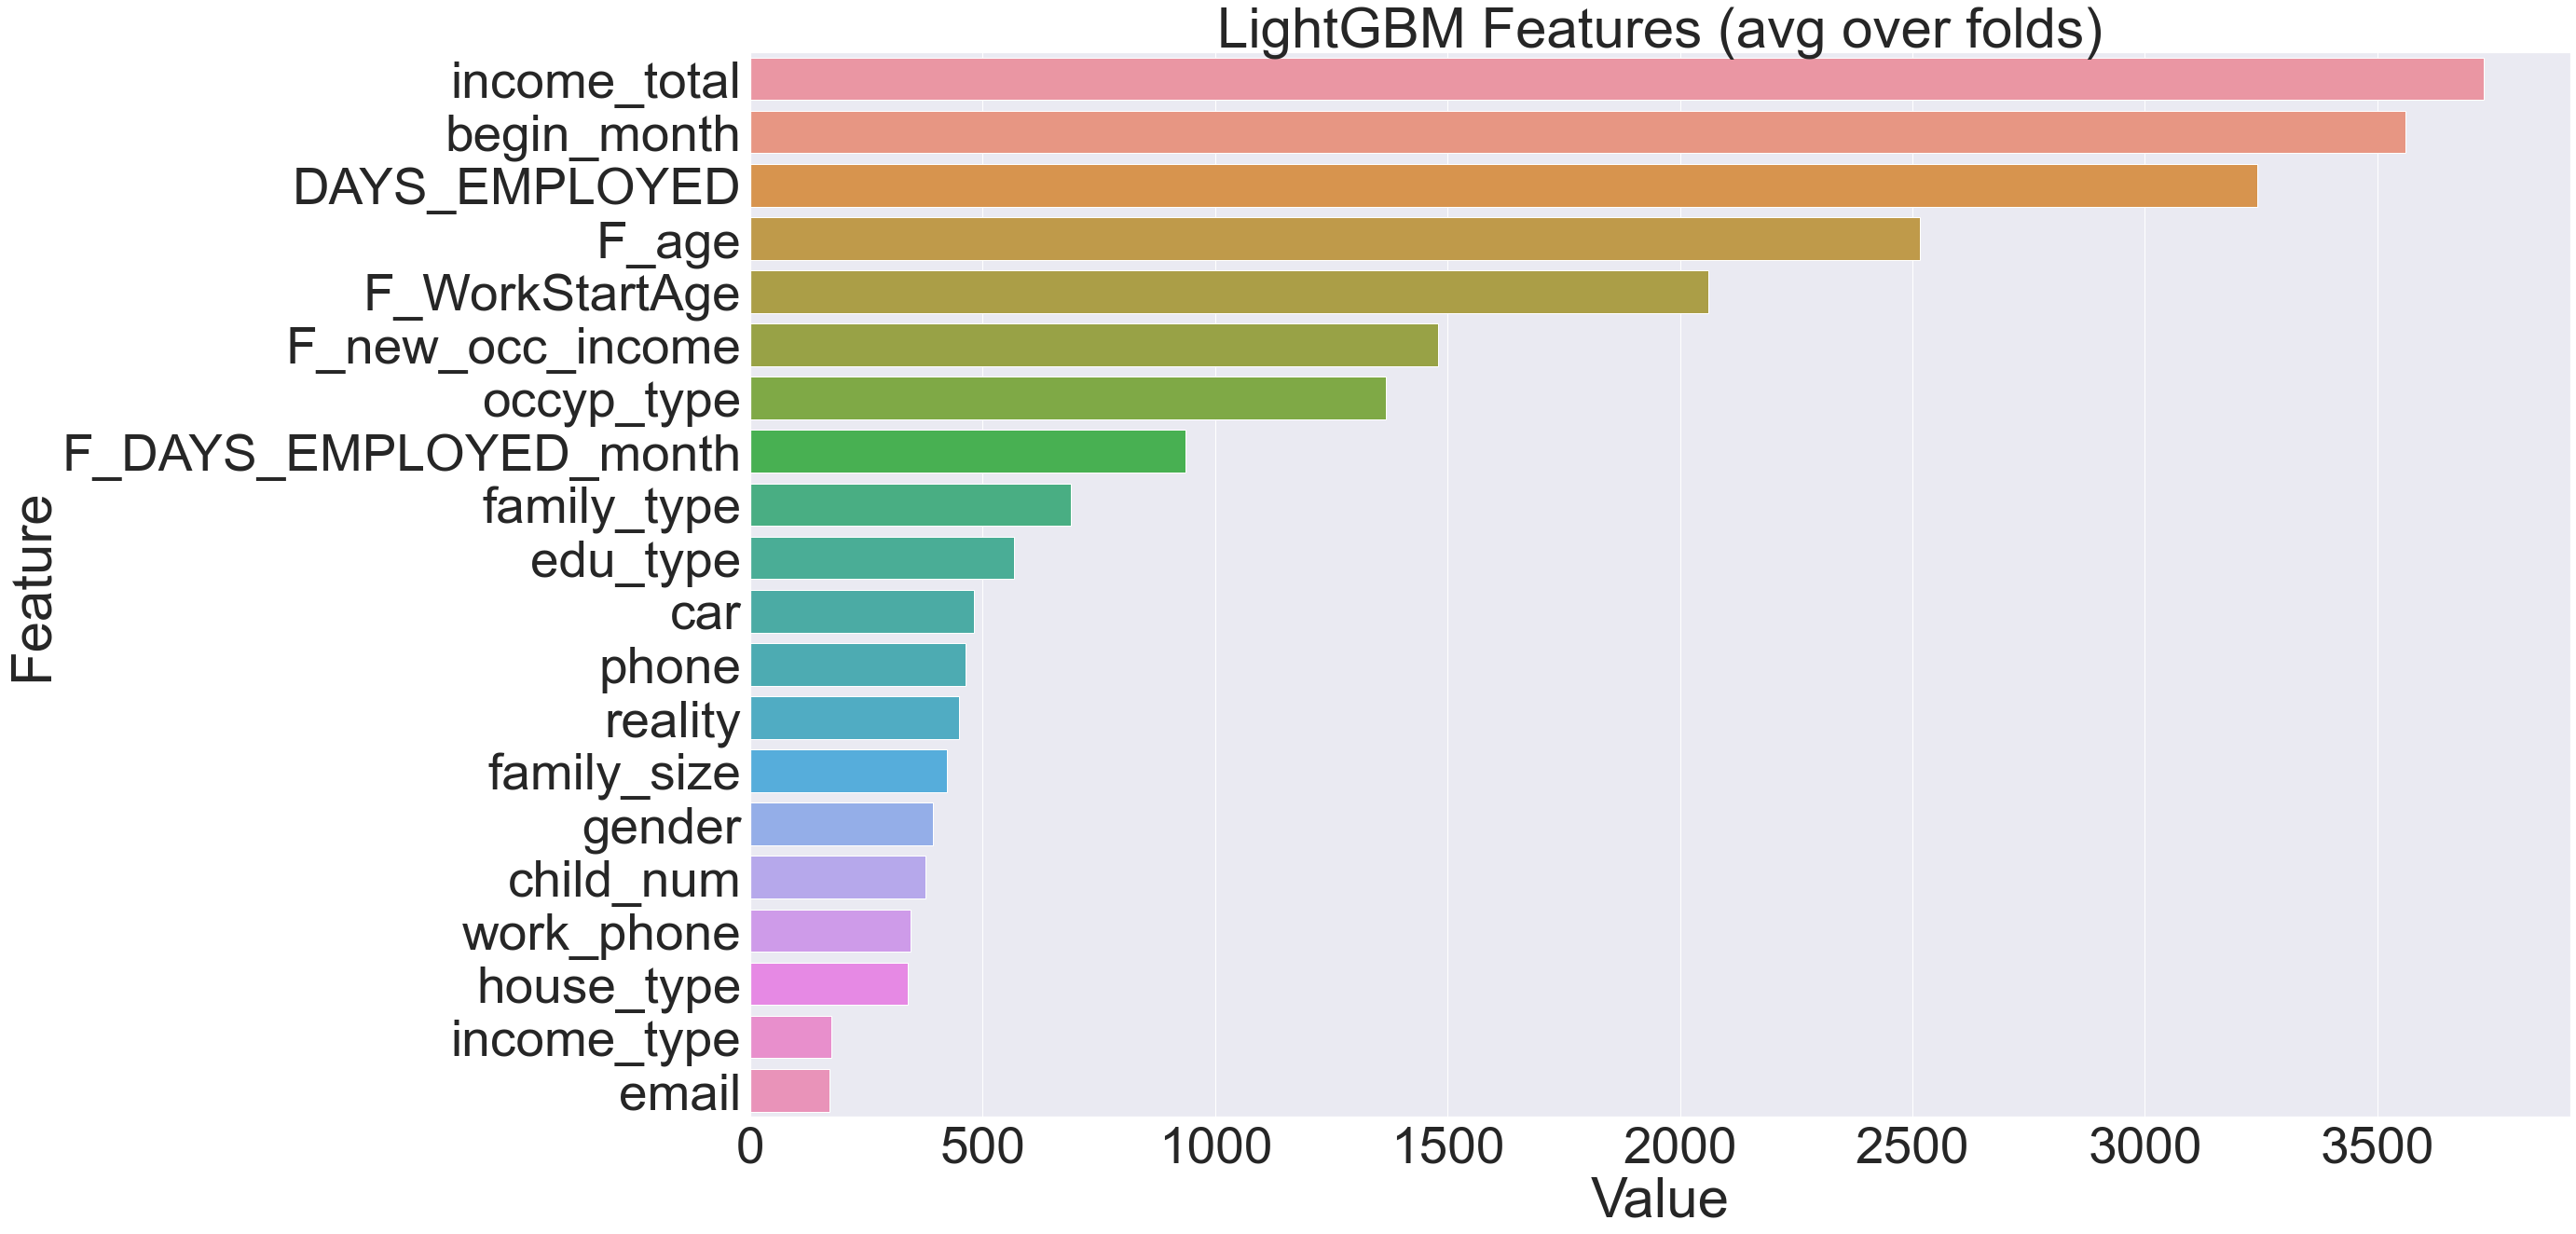

In [256]:
plotImpModels(lgb_models,train.drop(['credit'],axis=1))

In [184]:
perm = PermutationImportance(lgb).fit(X_train, y_train)
eli5.show_weights(perm,feature_names = train.drop('credit',axis=1).columns.tolist())

Weight,Feature
0.1103 ± 0.0026,begin_month
0.0525 ± 0.0011,income_total
0.0472 ± 0.0025,DAYS_EMPLOYED
0.0417 ± 0.0010,F_age
0.0362 ± 0.0014,F_WorkStartAge
0.0298 ± 0.0006,occyp_type
0.0183 ± 0.0009,F_DAYS_EMPLOYED_month
0.0137 ± 0.0013,family_type
0.0119 ± 0.0010,income_type
0.0097 ± 0.0016,edu_type


# random sort_test

In [346]:
total =[]

In [347]:
def ml(train):
    random.seed(42)
    lgb_models={}
    log_loss_val =[]
    for fold in range(5):
        print(f'===================================={fold+1}============================================')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                             train['credit'][train_idx].values, train['credit'][valid_idx].values 
        lgb = LGBMClassifier(n_estimators=1000)
        lgb.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                early_stopping_rounds=30,
               verbose=100)
        lgb_models[fold]=lgb
        pred = lgb.predict_proba(X_valid)
        log_loss_v = log_loss(y_valid,pred)
        log_loss_val.append(log_loss_v)
        print(f'================================================================================\n\n')
    return np.array(log_loss_val).mean()


In [348]:
for v in range(100):
    train_sort = trainLa.copy()

    lst = train_sort.F_new_occ_income.unique()
    random.shuffle(lst)
    dic = {a:b for a,b in zip(train_sort.F_new_occ_income.unique(),lst)}
    train_sort.F_new_occ_income = train_sort.F_new_occ_income.map(lambda x: dic[x])

    # %%time
    train =train_sort
    test = testLa

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    folds=[]
    for train_idx, valid_idx in skf.split(train, train['credit']):
        folds.append((train_idx, valid_idx))



    mean =str(ml(train))
    total.append([lst,mean])

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores d

Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi

[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	va

[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	va

[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	tr

Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


======

[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


====================================4============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650702	valid_1's multi_logloss: 0.752776
[200]	training's multi_logloss: 0.56398	val

[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


====================================4============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650702	valid_1's multi_logloss: 0.752776
[200]	training's multi_logloss: 0.56398	valid_1's multi_logloss: 0.740607
[300]	training's multi_logloss: 0.50037	vali

Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


====================================4============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650702	valid_1's multi_logloss: 0.752776
[200]	training's multi_logloss: 0.56398	valid_1's multi_logloss: 0.740607
[300]	training's multi_logloss: 0.50037	valid_1's multi_logloss: 0.735778
Early stopping, best iteration is:
[292]	tra

[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


====================================4============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650702	valid_1's multi_logloss: 0.752776
[200]	training's multi_logloss: 0.56398	valid_1's multi_logloss: 0.740607
[300]	training's multi_logloss: 0.50037	valid_1's multi_logloss: 0.735778
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.504269	valid_1's multi_logloss: 0.735524


====================================5============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.649748	val

[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


====================================4============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650702	valid_1's multi_logloss: 0.752776
[200]	training's multi_logloss: 0.56398	valid_1's multi_logloss: 0.740607
[300]	training's multi_logloss: 0.50037	valid_1's multi_logloss: 0.735778
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.504269	valid_1's multi_logloss: 0.735524


====================================5============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.649748	valid_1's multi_logloss: 0.753262
[200]	training's multi_logloss: 0.560868	v

[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


====================================4============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650702	valid_1's multi_logloss: 0.752776
[200]	training's multi_logloss: 0.56398	valid_1's multi_logloss: 0.740607
[300]	training's multi_logloss: 0.50037	valid_1's multi_logloss: 0.735778
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.504269	valid_1's multi_logloss: 0.735524


====================================5============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.649748	valid_1's multi_logloss: 0.753262
[200]	training's multi_logloss: 0.560868	valid_1's multi_logloss: 0.74158
[300]	training's multi_logloss: 0.499016	va

[100]	training's multi_logloss: 0.650702	valid_1's multi_logloss: 0.752776
[200]	training's multi_logloss: 0.56398	valid_1's multi_logloss: 0.740607
[300]	training's multi_logloss: 0.50037	valid_1's multi_logloss: 0.735778
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.504269	valid_1's multi_logloss: 0.735524


====================================5============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.649748	valid_1's multi_logloss: 0.753262
[200]	training's multi_logloss: 0.560868	valid_1's multi_logloss: 0.74158
[300]	training's multi_logloss: 0.499016	valid_1's multi_logloss: 0.739388
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.504618	valid_1's multi_logloss: 0.738683


====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	va

[200]	training's multi_logloss: 0.56398	valid_1's multi_logloss: 0.740607
[300]	training's multi_logloss: 0.50037	valid_1's multi_logloss: 0.735778
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.504269	valid_1's multi_logloss: 0.735524


====================================5============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.649748	valid_1's multi_logloss: 0.753262
[200]	training's multi_logloss: 0.560868	valid_1's multi_logloss: 0.74158
[300]	training's multi_logloss: 0.499016	valid_1's multi_logloss: 0.739388
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.504618	valid_1's multi_logloss: 0.738683


====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	va

[300]	training's multi_logloss: 0.50037	valid_1's multi_logloss: 0.735778
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.504269	valid_1's multi_logloss: 0.735524


====================================5============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.649748	valid_1's multi_logloss: 0.753262
[200]	training's multi_logloss: 0.560868	valid_1's multi_logloss: 0.74158
[300]	training's multi_logloss: 0.499016	valid_1's multi_logloss: 0.739388
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.504618	valid_1's multi_logloss: 0.738683


====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	v

[100]	training's multi_logloss: 0.649748	valid_1's multi_logloss: 0.753262
[200]	training's multi_logloss: 0.560868	valid_1's multi_logloss: 0.74158
[300]	training's multi_logloss: 0.499016	valid_1's multi_logloss: 0.739388
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.504618	valid_1's multi_logloss: 0.738683


====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	

[200]	training's multi_logloss: 0.560868	valid_1's multi_logloss: 0.74158
[300]	training's multi_logloss: 0.499016	valid_1's multi_logloss: 0.739388
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.504618	valid_1's multi_logloss: 0.738683


====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	v

[300]	training's multi_logloss: 0.499016	valid_1's multi_logloss: 0.739388
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.504618	valid_1's multi_logloss: 0.738683


====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	

Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi

[100]	training's multi_logloss: 0.650103	valid_1's multi_logloss: 0.752539
[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	va

[200]	training's multi_logloss: 0.562839	valid_1's multi_logloss: 0.733407
[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	va

[300]	training's multi_logloss: 0.500345	valid_1's multi_logloss: 0.729304
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	tr

Early stopping, best iteration is:
[346]	training's multi_logloss: 0.475901	valid_1's multi_logloss: 0.728309


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.647082	valid_1's multi_logloss: 0.766595
[200]	training's multi_logloss: 0.56003	valid_1's multi_logloss: 0.754082
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.534433	valid_1's multi_logloss: 0.752024


====================================3============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.65162	valid_1's multi_logloss: 0.75889
[200]	training's multi_logloss: 0.564996	valid_1's multi_logloss: 0.744722
[300]	training's multi_logloss: 0.499884	valid_1's multi_logloss: 0.740465
Early stopping, best iteration is:
[291]	training's multi_logloss: 0.504942	valid_1's multi_logloss: 0.739826


======

KeyboardInterrupt: 

In [349]:
pd.DataFrame(total)

,0,1
0,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
1,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
2,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
3,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
4,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
...,...,...
64,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
65,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
66,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641
67,"[35, 39, 64, 60, 4, 54, 41, 32, 14, 9, 55, 34,...",0.7388732114205641


# submission

In [32]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

submit.to_csv('/Users/ds/Documents/project/Dacon_project/dacon_credit/ds/code/submit_ensemble.csv', index=False) # 0.7272812144

submit.head(20)

,index,0,1,2
0,26457,0.046968,0.085168,0.867864
1,26458,0.176937,0.177003,0.646060
2,26459,0.036071,0.094688,0.869241
3,26460,0.122966,0.091751,0.785283
4,26461,0.079321,0.219833,0.700846
5,26462,0.087292,0.112890,0.799818
6,26463,0.341635,0.657957,0.000408
7,26464,0.083645,0.137033,0.779323
8,26465,0.062595,0.146153,0.791252
9,26466,0.051856,0.282588,0.665556
